# Принятие решений в бизнесе

### Цель исследования

Приоритизировать гипотезы для увеличения выручки, запустить A/B-тест и пронализировать результаты. 

<b> Имеющиеся данные: </b> 

Файл /datasets/hypothesis.csv

* Hypothesis — краткое описание гипотезы;
* Reach — охват пользователей по 10-балльной шкале;
* Impact — влияние на пользователей по 10-балльной шкале;
* Confidence — уверенность в гипотезе по 10-балльной шкале;
* Efforts — затраты ресурсов на проверку гипотезы по 10-балльной шкале. Чем больше значение Efforts, тем дороже проверка гипотезы.

Файл /datasets/orders.csv

* transactionId — идентификатор заказа;
* visitorId — идентификатор пользователя, совершившего заказ;
* date — дата, когда был совершён заказ;
* revenue — выручка заказа;
* group — группа A/B-теста, в которую попал заказ.


Файл /datasets/visitors.csv

* date — дата;
* group — группа A/B-теста;
* visitors — количество пользователей в указанную дату в указанной группе A/B-теста


### Приоритизация гипотез

#### Изучение и предобработка данных

In [1]:
import pandas as pd  # импортируем необходимые для исследования библиотеки
import matplotlib.pyplot as plt
import numpy as np
import scipy.stats as stats

In [2]:
try:  # Загружаем датафреймы
    hypothesis = pd.read_csv('/datasets/hypothesis.csv')
    orders = pd.read_csv('/datasets/orders.csv')
    visitors = pd.read_csv('/datasets/visitors.csv')
except:
    hypothesis = pd.read_csv('https://code.s3.yandex.net/datasets/hypothesis.csv')
    orders = pd.read_csv('https://code.s3.yandex.net/datasets/orders.csv')
    visitors = pd.read_csv('https://code.s3.yandex.net/datasets/visitors.csv')

In [3]:
hypothesis.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9 entries, 0 to 8
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Hypothesis  9 non-null      object
 1   Reach       9 non-null      int64 
 2   Impact      9 non-null      int64 
 3   Confidence  9 non-null      int64 
 4   Efforts     9 non-null      int64 
dtypes: int64(4), object(1)
memory usage: 492.0+ bytes


In [4]:
orders.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1197 entries, 0 to 1196
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   transactionId  1197 non-null   int64 
 1   visitorId      1197 non-null   int64 
 2   date           1197 non-null   object
 3   revenue        1197 non-null   int64 
 4   group          1197 non-null   object
dtypes: int64(3), object(2)
memory usage: 46.9+ KB


In [5]:
visitors.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 62 entries, 0 to 61
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   date      62 non-null     object
 1   group     62 non-null     object
 2   visitors  62 non-null     int64 
dtypes: int64(1), object(2)
memory usage: 1.6+ KB


In [6]:
hypothesis.duplicated().sum()

0

In [7]:
hypothesis.isna().sum()

Hypothesis    0
Reach         0
Impact        0
Confidence    0
Efforts       0
dtype: int64

In [8]:
orders.duplicated().sum()

0

In [9]:
orders.isna().sum()

transactionId    0
visitorId        0
date             0
revenue          0
group            0
dtype: int64

In [10]:
visitors.duplicated().sum()

0

In [11]:
visitors.isna().sum()

date        0
group       0
visitors    0
dtype: int64

Рассмотрим имеющиеся таблицы с данными более внимательно. Пропущенные значения и дупликаты отсутствуют, но есть неточности в названиях столбцов, а также ошибки в их типах

In [12]:
pd.set_option('max_colwidth', 200)

In [13]:
hypothesis.head()

,Hypothesis,Reach,Impact,Confidence,Efforts
0,"Добавить два новых канала привлечения трафика, что позволит привлекать на 30% больше пользователей",3,10,8,6
1,"Запустить собственную службу доставки, что сократит срок доставки заказов",2,5,4,10
2,"Добавить блоки рекомендаций товаров на сайт интернет магазина, чтобы повысить конверсию и средний чек заказа",8,3,7,3
3,"Изменить структура категорий, что увеличит конверсию, т.к. пользователи быстрее найдут нужный товар",8,3,3,8
4,"Изменить цвет фона главной страницы, чтобы увеличить вовлеченность пользователей",3,1,1,1


In [14]:
orders.head()

,transactionId,visitorId,date,revenue,group
0,3667963787,3312258926,2019-08-15,1650,B
1,2804400009,3642806036,2019-08-15,730,B
2,2961555356,4069496402,2019-08-15,400,A
3,3797467345,1196621759,2019-08-15,9759,B
4,2282983706,2322279887,2019-08-15,2308,B


In [15]:
visitors.head()

,date,group,visitors
0,2019-08-01,A,719
1,2019-08-02,A,619
2,2019-08-03,A,507
3,2019-08-04,A,717
4,2019-08-05,A,756


Исправим неточности в столбцах

In [16]:
hypothesis.columns = hypothesis.columns.str.lower() # Приводим названия столбцов в таблице hypothesis к нижнему регистру

In [17]:
hypothesis['hypothesis'].nunique() 

9

In [18]:
hypothesis['hypothesis'].unique() # неявные дупликаты отсутствуют

array(['Добавить два новых канала привлечения трафика, что позволит привлекать на 30% больше пользователей',
       'Запустить собственную службу доставки, что сократит срок доставки заказов',
       'Добавить блоки рекомендаций товаров на сайт интернет магазина, чтобы повысить конверсию и средний чек заказа',
       'Изменить структура категорий, что увеличит конверсию, т.к. пользователи быстрее найдут нужный товар',
       'Изменить цвет фона главной страницы, чтобы увеличить вовлеченность пользователей',
       'Добавить страницу отзывов клиентов о магазине, что позволит увеличить количество заказов',
       'Показать на главной странице баннеры с актуальными акциями и распродажами, чтобы увеличить конверсию',
       'Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок',
       'Запустить акцию, дающую скидку на товар в день рождения'],
      dtype=object)

Неявные повторы отсутствуют

In [19]:
orders = orders.rename(columns={"transactionId": "transaction_id", "visitorId": "visitor_id"}) # приводим столбцы к нижнему регистру

In [20]:
orders['date'] = pd.to_datetime(orders['date'], format='%Y-%m-%d') # меняем формат столбцов с датами

In [21]:
visitors['date'] = pd.to_datetime(visitors['date'], format='%Y-%m-%d')

Предобработка завершена, данные готовы к дальнейшему использованию

#### Примените фреймворк ICE для приоритизации гипотез. Отсортируйте их по убыванию приоритета.

In [22]:
hypothesis['ice'] = hypothesis['impact'] * hypothesis['confidence'] / hypothesis['efforts'] 

In [23]:
hypothesis[['hypothesis','ice']].sort_values(by='ice',ascending=False).round(1)

,hypothesis,ice
8,"Запустить акцию, дающую скидку на товар в день рождения",16.2
0,"Добавить два новых канала привлечения трафика, что позволит привлекать на 30% больше пользователей",13.3
7,"Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок",11.2
6,"Показать на главной странице баннеры с актуальными акциями и распродажами, чтобы увеличить конверсию",8.0
2,"Добавить блоки рекомендаций товаров на сайт интернет магазина, чтобы повысить конверсию и средний чек заказа",7.0
1,"Запустить собственную службу доставки, что сократит срок доставки заказов",2.0
5,"Добавить страницу отзывов клиентов о магазине, что позволит увеличить количество заказов",1.3
3,"Изменить структура категорий, что увеличит конверсию, т.к. пользователи быстрее найдут нужный товар",1.1
4,"Изменить цвет фона главной страницы, чтобы увеличить вовлеченность пользователей",1.0


#### Примените фреймворк RICE для приоритизации гипотез. Отсортируйте их по убыванию приоритета.

In [24]:
hypothesis['rice'] = hypothesis['reach'] * hypothesis['impact'] * hypothesis['confidence'] / hypothesis['efforts'] 

In [25]:
hypothesis[['hypothesis','rice']].sort_values(by='rice',ascending=False).round(1)

,hypothesis,rice
7,"Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок",112.0
2,"Добавить блоки рекомендаций товаров на сайт интернет магазина, чтобы повысить конверсию и средний чек заказа",56.0
0,"Добавить два новых канала привлечения трафика, что позволит привлекать на 30% больше пользователей",40.0
6,"Показать на главной странице баннеры с актуальными акциями и распродажами, чтобы увеличить конверсию",40.0
8,"Запустить акцию, дающую скидку на товар в день рождения",16.2
3,"Изменить структура категорий, что увеличит конверсию, т.к. пользователи быстрее найдут нужный товар",9.0
1,"Запустить собственную службу доставки, что сократит срок доставки заказов",4.0
5,"Добавить страницу отзывов клиентов о магазине, что позволит увеличить количество заказов",4.0
4,"Изменить цвет фона главной страницы, чтобы увеличить вовлеченность пользователей",3.0


#### Укажите, как изменилась приоритизация гипотез при применении RICE вместо ICE. Объясните, почему так произошло.

In [26]:
hypothesis[['hypothesis','ice', 'rice']].sort_values(by='rice', ascending=False).head(5)

,hypothesis,ice,rice
7,"Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок",11.200000,112.0
2,"Добавить блоки рекомендаций товаров на сайт интернет магазина, чтобы повысить конверсию и средний чек заказа",7.000000,56.0
0,"Добавить два новых канала привлечения трафика, что позволит привлекать на 30% больше пользователей",13.333333,40.0
6,"Показать на главной странице баннеры с актуальными акциями и распродажами, чтобы увеличить конверсию",8.000000,40.0
8,"Запустить акцию, дающую скидку на товар в день рождения",16.200000,16.2


При применении RICE учитывается охват аудитории (reach), которую затронут изменения. Соответственно, меняется и приоритизация гипотез - без учета показателя Reach наиболее важными гипотезами являются №№8, 0 и 7, то уже с учетом охвата наиболее приоритетной становится гипотеза №7, затем - №№2 и 0.

#### Выводы по первой части

Ознакомились с данными, осуществили предобработку, приоритизировали необходимые гипотезы

### Анализ A/B теста

#### Постройте график кумулятивной выручки по группам. Сделайте выводы и предположения.

In [28]:
datesGroups = orders[['date','group']].drop_duplicates().sort_values(by=['date', 'group'])

ordersAggregated = datesGroups.apply(lambda x: orders[np.logical_and(x['date'] >= orders['date'], x['group']==orders['group'])]\
.agg({'date':'max', 'group':'max', 'transaction_id':'nunique', 'visitor_id':'nunique', 'revenue':'sum'}), axis = 1)
ordersAggregated.columns = ['date', 'group', 'orders', 'buyers', 'revenue']

visitorsAggregated = datesGroups.apply(lambda x: visitors[np.logical_and(x['date'] >= visitors['date'], x['group']==visitors['group'])]\
.agg({'date':'max', 'group':'max', 'visitors':'sum'}), axis = 1)

cumulativeData = ordersAggregated.merge(visitorsAggregated, left_on=['date', 'group'], right_on=['date', 'group'])

cumulativeData.head(5)

,date,group,orders,buyers,revenue,visitors
0,2019-08-01,A,24,20,148579,719
1,2019-08-01,B,21,20,101217,713
2,2019-08-02,A,44,38,242401,1338
3,2019-08-02,B,45,43,266748,1294
4,2019-08-03,A,68,62,354874,1845


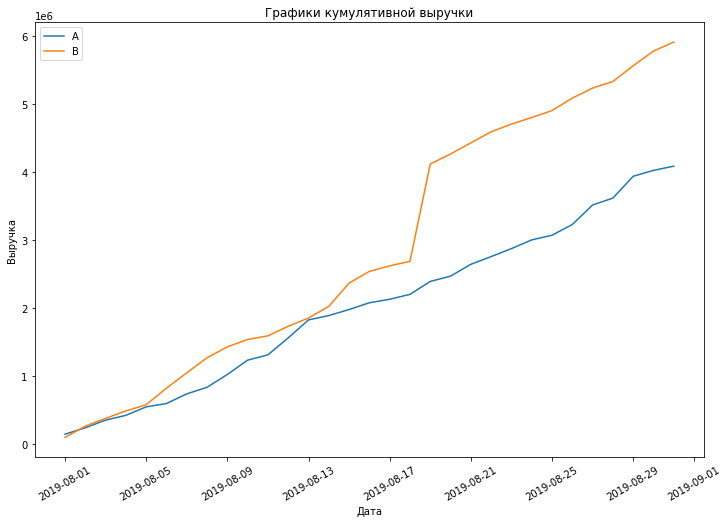

In [29]:
plt.figure(figsize=(12, 8))

# датафрейм с кумулятивным количеством заказов и кумулятивной выручкой по дням в группе А
cumulativeRevenueA = cumulativeData[cumulativeData['group']=='A'][['date','revenue', 'orders']]

# датафрейм с кумулятивным количеством заказов и кумулятивной выручкой по дням в группе B
cumulativeRevenueB = cumulativeData[cumulativeData['group']=='B'][['date','revenue', 'orders']]

# Строим график выручки группы А
plt.plot(cumulativeRevenueA['date'], cumulativeRevenueA['revenue'], label='A')

# Строим график выручки группы B
plt.plot(cumulativeRevenueB['date'], cumulativeRevenueB['revenue'], label='B')

plt.xlabel('Дата')
plt.ylabel('Выручка')
plt.title('Графики кумулятивной выручки')
plt.legend()
plt.xticks(rotation=30)
plt.show()

Группа А показывает ровный, линейный рост. У группы В произошел резкий скачок 17 августа. Возможно, выброс

#### Постройте график кумулятивного среднего чека по группам. Сделайте выводы и предположения.

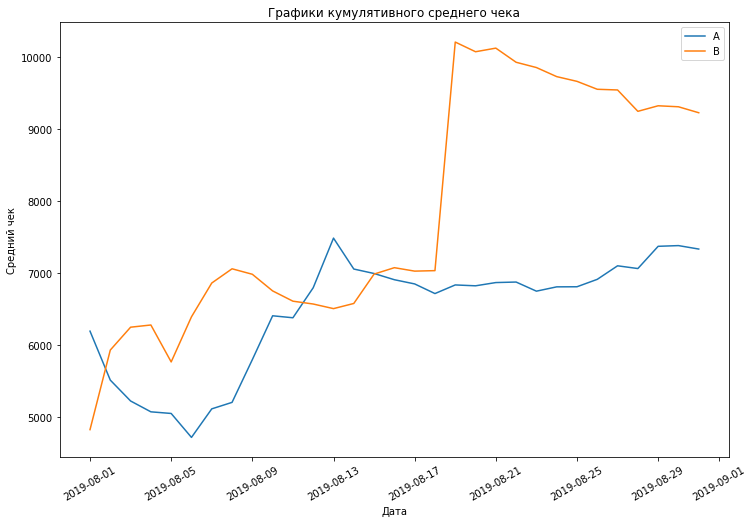

In [30]:
plt.figure(figsize=(12, 8))

plt.plot(cumulativeRevenueA['date'], cumulativeRevenueA['revenue']/cumulativeRevenueA['orders'], label = 'A')
plt.plot(cumulativeRevenueB['date'], cumulativeRevenueB['revenue']/cumulativeRevenueB['orders'], label = 'B')
plt.title('Графики кумулятивного среднего чека')
plt.ylabel('Средний чек')
plt.xlabel('Дата')
plt.legend()
plt.xticks(rotation=30)
plt.show()

Также виден резкий скачок второй группы начиная с 17 августа

#### Постройте график относительного изменения кумулятивного среднего чека группы B к группе A. Сделайте выводы и предположения.

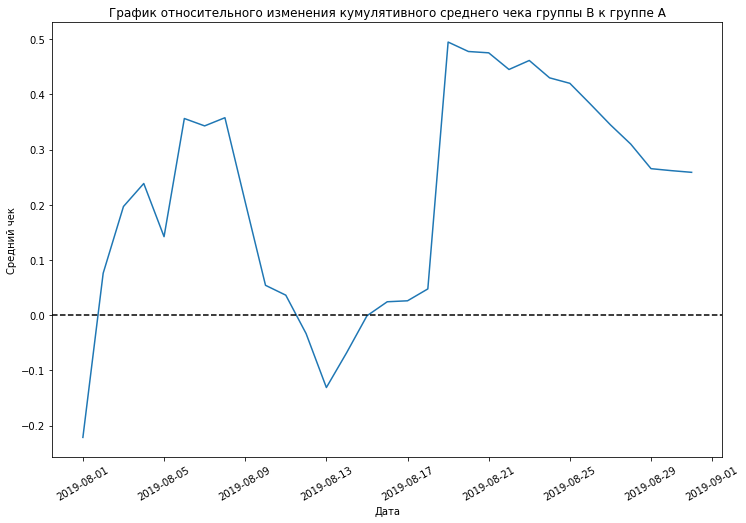

In [31]:
plt.figure(figsize=(12, 8))

# собираем данные в одном датафрейме
mergedCumulativeRevenue = cumulativeRevenueA.merge(cumulativeRevenueB, left_on='date', right_on='date', how='left', suffixes=['A', 'B'])

# cтроим отношение средних чеков
plt.plot(mergedCumulativeRevenue['date'], (mergedCumulativeRevenue['revenueB']/mergedCumulativeRevenue['ordersB'])/(mergedCumulativeRevenue['revenueA']/mergedCumulativeRevenue['ordersA'])-1)

# добавляем ось X
plt.axhline(y=0, color='black', linestyle='--') 


plt.xlabel('Дата')
plt.ylabel('Средний чек')
plt.title('График относительного изменения кумулятивного среднего чека группы B к группе A')
plt.xticks(rotation=30)
plt.show()

На графике видны резкие колебания, которые могут быть связаны с аномальными данными и выбросами

#### Постройте график кумулятивного среднего количества заказов на посетителя по группам. Сделайте выводы и предположения.

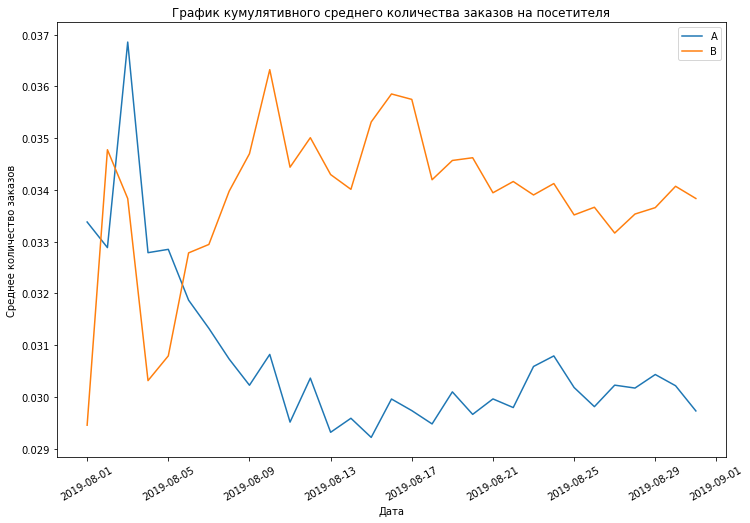

In [32]:
plt.figure(figsize=(12, 8))

cumulativeData['conversion'] = cumulativeData['orders']/cumulativeData['visitors']

# отделяем данные по группе A
cumulativeDataA = cumulativeData[cumulativeData['group']=='A']

# отделяем данные по группе B
cumulativeDataB = cumulativeData[cumulativeData['group']=='B']

# строим графики
plt.plot(cumulativeDataA['date'], cumulativeDataA['conversion'], label='A')
plt.plot(cumulativeDataB['date'], cumulativeDataB['conversion'], label='B')
plt.legend()
plt.xlabel('Дата')
plt.ylabel('Среднее количество заказов')
plt.title('График кумулятивного среднего количества заказов на посетителя');
plt.xticks(rotation=30)
plt.show()

В среднем, число заказов у группы B больше. После 9 августа обе группы шли достаточно линейны, без резких скачков и спадов

#### Постройте график относительного изменения кумулятивного среднего количества заказов на посетителя группы B к группе A. Сделайте выводы и предположения.

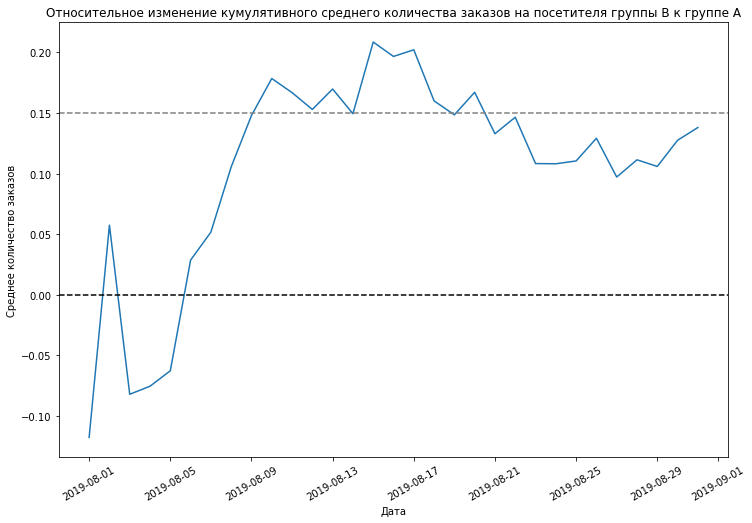

In [49]:
plt.figure(figsize=(12, 8))

mergedCumulativeConversions = cumulativeDataA[['date','conversion']].merge(cumulativeDataB[['date','conversion']], left_on='date', right_on='date', how='left', suffixes=['A', 'B'])

plt.plot(mergedCumulativeConversions['date'], mergedCumulativeConversions['conversionB']/mergedCumulativeConversions['conversionA']-1)

plt.title('Относительное изменение кумулятивного среднего количества заказов на посетителя группы B к группе A')
plt.ylabel('Среднее количество заказов')
plt.xlabel('Дата')
plt.axhline(y=0, color='black', linestyle='--')
plt.axhline(y=0.15, color='grey', linestyle='--')
plt.xticks(rotation=30)
plt.show()

Среднее количество заказов группы В показывает рост и в целом выглядит предпочтительнее первой группы

#### Постройте точечный график количества заказов по пользователям. Сделайте выводы и предположения.

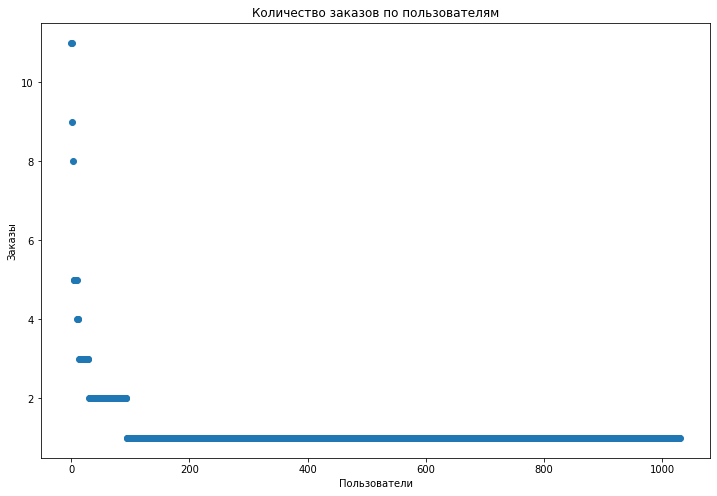

In [34]:
plt.figure(figsize=(12, 8))

ordersByUsers = orders.groupby('visitor_id', as_index = False).agg({'transaction_id':'nunique'}).sort_values(by='transaction_id', ascending = False)
ordersByUsers.columns = ['visitor_id', 'orders']

x_values = pd.Series(range(0, len(ordersByUsers)))

plt.scatter(x_values, ordersByUsers['orders'])
plt.ylabel('Заказы')
plt.xlabel('Пользователи')
plt.title('Количество заказов по пользователям')
plt.show()

Большинство пользователей совершают по 1, реже - по 2 заказа. На графике отчетливо видны аномалии (в том числе более 10 заказов).

#### Посчитайте 95-й и 99-й перцентили количества заказов на пользователя. Выберите границу для определения аномальных пользователей.

In [35]:
np.percentile(ordersByUsers['orders'], [95, 99])

array([2., 4.])

Только 5% пользователей совершают более 2 заказов, 1% пользователей - более 4 заказов. Целесообразно будет отбросить все заказы свыше 2. 

#### Постройте точечный график стоимостей заказов. Сделайте выводы и предположения.

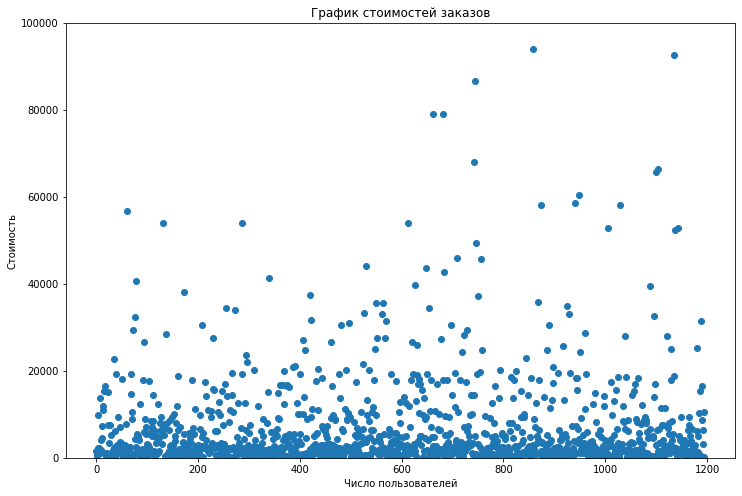

In [36]:
x_values = pd.Series(range(0,len(orders['revenue'])))
plt.figure(figsize=(12, 8))
plt.scatter(x_values, orders['revenue'])
plt.ticklabel_format(axis = 'y', style = 'plain')
plt.ylim([0, 100000])
plt.xlabel('Число пользователей')
plt.ylabel('Стоимость')
plt.title('График стоимостей заказов');

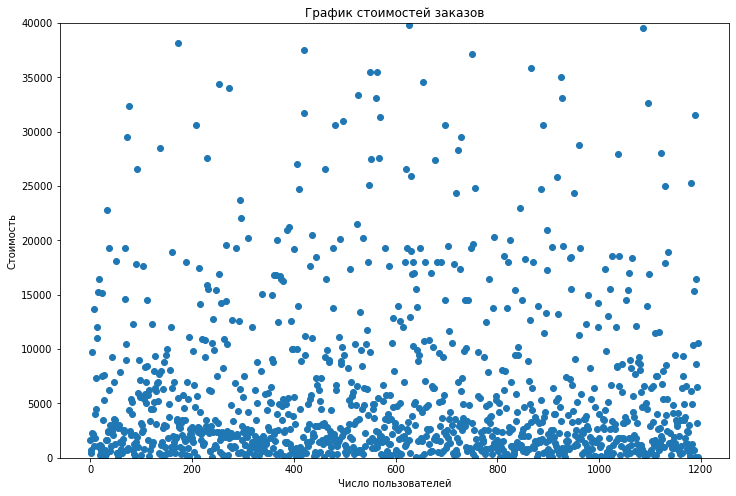

In [37]:
x_values = pd.Series(range(0,len(orders['revenue'])))
plt.figure(figsize=(12, 8))
plt.scatter(x_values, orders['revenue'])
plt.ticklabel_format(axis = 'y', style = 'plain')
plt.ylim([0, 40000])
plt.xlabel('Число пользователей')
plt.ylabel('Стоимость')
plt.title('График стоимостей заказов');

Большинство заказов не превышает 20000 y.e. 

#### Посчитайте 95-й и 99-й перцентили стоимости заказов. Выберите границу для определения аномальных заказов.

In [38]:
np.percentile(orders['revenue'], [95, 99])

array([28000. , 58233.2])

Лишь 5% заказов дороже 28000 и 1% - 58233 y.e. Возьмем за границу 95% заказов не дороже 28000

#### Посчитайте статистическую значимость различий в среднем количестве заказов на посетителя между группами по «сырым» данным. Сделайте выводы и предположения.

Прежде всего, обозначим гипотезы. 

* Нулевая гипотеза H0 - различия в среднем количестве заказов на посетителя между группами отсутсвуют либо между ними отсутствует статистически значимая разница.

* Альтернативная гипотеза H1 - различия между группами есть.

Ранее мы видели подтверждения скорее в пользу альтернативнной гипотезы, но это было до того как мы выделили аномальные данные.

Поскольку в данных присутствуют выбросы, мы не можем использовать алгебраические метрики, поэтому для проверки гипотез будем использовать тест Генри Манна и Доналда Уитни. В качестве уровня статистической значимости установим 0,05. Если p-value превысит данный показатель, то подтверждаем нулевую гипотезу, в противном случае - альтернативную. 

In [39]:
visitorsADaily = visitors[visitors['group'] == 'A'][['date', 'visitors']]
visitorsADaily.columns = ['date', 'visitorsPerDateA']

visitorsACummulative = visitorsADaily.apply(
    lambda x: visitorsADaily[visitorsADaily['date'] <= x['date']].agg(
        {'date': 'max', 'visitorsPerDateA': 'sum'}
    ),
    axis=1,
)
visitorsACummulative.columns = ['date', 'visitorsCummulativeA']

visitorsBDaily = visitors[visitors['group'] == 'B'][['date', 'visitors']]
visitorsBDaily.columns = ['date', 'visitorsPerDateB']

visitorsBCummulative = visitorsBDaily.apply(
    lambda x: visitorsBDaily[visitorsBDaily['date'] <= x['date']].agg(
        {'date': 'max', 'visitorsPerDateB': 'sum'}
    ),
    axis=1,
)
visitorsBCummulative.columns = ['date', 'visitorsCummulativeB']

ordersADaily = (
    orders[orders['group'] == 'A'][['date', 'transaction_id', 'visitor_id', 'revenue']]
    .groupby('date', as_index=False)
    .agg({'transaction_id': pd.Series.nunique, 'revenue': 'sum'})
)
ordersADaily.columns = ['date', 'ordersPerDateA', 'revenuePerDateA']

ordersACummulative = ordersADaily.apply(
    lambda x: ordersADaily[ordersADaily['date'] <= x['date']].agg(
        {'date': 'max', 'ordersPerDateA': 'sum', 'revenuePerDateA': 'sum'}
    ),
    axis=1,
).sort_values(by=['date'])
ordersACummulative.columns = [
    'date',
    'ordersCummulativeA',
    'revenueCummulativeA',
]

ordersBDaily = (
    orders[orders['group'] == 'B'][['date', 'transaction_id', 'visitor_id', 'revenue']]
    .groupby('date', as_index=False)
    .agg({'transaction_id': pd.Series.nunique, 'revenue': 'sum'})
)
ordersBDaily.columns = ['date', 'ordersPerDateB', 'revenuePerDateB']

ordersBCummulative = ordersBDaily.apply(
    lambda x: ordersBDaily[ordersBDaily['date'] <= x['date']].agg(
        {'date': 'max', 'ordersPerDateB': 'sum', 'revenuePerDateB': 'sum'}
    ),
    axis=1,
).sort_values(by=['date'])
ordersBCummulative.columns = [
    'date',
    'ordersCummulativeB',
    'revenueCummulativeB',
]

data = (
    ordersADaily.merge(
        ordersBDaily, left_on='date', right_on='date', how='left'
    )
    .merge(ordersACummulative, left_on='date', right_on='date', how='left')
    .merge(ordersBCummulative, left_on='date', right_on='date', how='left')
    .merge(visitorsADaily, left_on='date', right_on='date', how='left')
    .merge(visitorsBDaily, left_on='date', right_on='date', how='left')
    .merge(visitorsACummulative, left_on='date', right_on='date', how='left')
    .merge(visitorsBCummulative, left_on='date', right_on='date', how='left')
)
ordersByUsersA = (
    orders[orders['group'] == 'A']
    .groupby('visitor_id', as_index=False)
    .agg({'transaction_id': pd.Series.nunique})
)
ordersByUsersA.columns = ['visitor_id', 'orders']

ordersByUsersB = (
    orders[orders['group'] == 'B']
    .groupby('visitor_id', as_index=False)
    .agg({'transaction_id': pd.Series.nunique})
)
ordersByUsersB.columns = ['visitor_id', 'orders'] 
pd.Series(0, index=np.arange(data['visitorsPerDateA'].sum() - len(ordersByUsersA['orders'])), name='orders')
[ordersByUsersA['orders'],pd.Series(0, index=np.arange(data['visitorsPerDateA'].sum() - len(ordersByUsersA['orders'])), name='orders')] 
sampleA = pd.concat([ordersByUsersA['orders'],pd.Series(0, index=np.arange(data['visitorsPerDateA'].sum() - len(ordersByUsersA['orders'])), name='orders')],axis=0)

sampleB = pd.concat([ordersByUsersB['orders'],pd.Series(0, index=np.arange(data['visitorsPerDateB'].sum() - len(ordersByUsersB['orders'])), name='orders')],axis=0) 
ordersByUsersA = (
    orders[orders['group'] == 'A']
    .groupby('visitor_id', as_index=False)
    .agg({'transaction_id': pd.Series.nunique})
)
ordersByUsersA.columns = ['visitor_id', 'orders']

ordersByUsersB = (
    orders[orders['group'] == 'B']
    .groupby('visitor_id', as_index=False)
    .agg({'transaction_id': pd.Series.nunique})
)
ordersByUsersB.columns = ['visitor_id', 'orders']

sampleA = pd.concat(
    [
        ordersByUsersA['orders'],
        pd.Series(
            0,
            index=np.arange(
                data['visitorsPerDateA'].sum() - len(ordersByUsersA['orders'])
            ),
            name='orders',
        ),
    ],
    axis=0,
)

sampleB = pd.concat(
    [
        ordersByUsersB['orders'],
        pd.Series(
            0,
            index=np.arange(
                data['visitorsPerDateB'].sum() - len(ordersByUsersB['orders'])
            ),
            name='orders',
        ),
    ],
    axis=0,
)
alpha = .05 
results = stats.mannwhitneyu(sampleA, sampleB)


print('p-value: ', '{0:.5f}'.format(results.pvalue))

if results.pvalue < alpha:
    print('Отвергаем нулевую гипотезу и выбираем альтернативную')
else:
    print('Не получилось отвергнуть нулевую гипотезу') 

print('Соотношение среднего количества заказов пользователей группы B к пользователям группы А составляет:', "{0:.5f}".format(sampleB.mean() / sampleA.mean() - 1))

p-value:  0.01679
Отвергаем нулевую гипотезу и выбираем альтернативную
Соотношение среднего количества заказов пользователей группы B к пользователям группы А составляет: 0.13808


#### Посчитайте статистическую значимость различий в среднем чеке заказа между группами по «сырым» данным. Сделайте выводы и предположения.

По аналогии с прошлой задачей определяем гипотезы: 

* Нулевая гипотеза H0 - различия в среднем чеке заказа между группами по «сырым» данным отсутствуют.

* Альтернативная гипотеза Н1 - различия между группами есть. 

Воспользуемся тем же тестом и уровнем статистической значимости

In [40]:
results = stats.mannwhitneyu(orders[orders['group']=='A']['revenue'], orders[orders['group']=='B']['revenue'])


print('p-value: ', '{0:.5f}'.format(results.pvalue))

if results.pvalue < alpha:
    print('Отвергаем нулевую гипотезу и выбираем альтернативную')
else:
    print('Не получилось отвергнуть нулевую гипотезу') 
print('Соотношение среднего чека заказов пользователей группы B к пользователям группы А составляет:', "{0:.5f}".format(orders[orders['group']=='B']['revenue'].mean()/orders[orders['group']=='A']['revenue'].mean()-1))


p-value:  0.72929
Не получилось отвергнуть нулевую гипотезу
Соотношение среднего чека заказов пользователей группы B к пользователям группы А составляет: 0.25871


#### Посчитайте статистическую значимость различий в среднем количестве заказов на посетителя между группами по «очищенным» данным. Сделайте выводы и предположения.

In [41]:
limit_orders = np.percentile(ordersByUsers['orders'], 95)
expensive_orders = np.percentile(orders['revenue'], 95)

In [42]:
usersWithManyOrders = pd.concat(
    [
        ordersByUsersA[ordersByUsersA['orders'] > limit_orders]['visitor_id'],
        ordersByUsersB[ordersByUsersB['orders'] > limit_orders]['visitor_id'],
    ],
    axis=0,
)
usersWithExpensiveOrders = orders[orders['revenue'] > expensive_orders]['visitor_id']
abnormalUsers = (
    pd.concat([usersWithManyOrders, usersWithExpensiveOrders], axis=0)
    .drop_duplicates()
    .sort_values()
)

abnormalUsers_count = len(abnormalUsers)
total_users = len(orders['visitor_id'].unique())
abnormalUsers_ratio = abnormalUsers_count / total_users


print('Кол-во аномальных пользователей: {}'.format(abnormalUsers_count))
print('Относительное кол-во аномальных пользователей: {:.2%}'.format(abnormalUsers_ratio))

Кол-во аномальных пользователей: 74
Относительное кол-во аномальных пользователей: 7.18%


* Нулевая гипотеза H0 - различия в среднем количестве заказов на посетителя между группами отсутсвуют либо между ними отсутствует статистически значимая разница.

* Альтернативная гипотеза H1 - различия между группами есть.

In [43]:
sampleAFiltered = pd.concat(
    [
        ordersByUsersA[
            np.logical_not(ordersByUsersA['visitor_id'].isin(abnormalUsers))
        ]['orders'],
        pd.Series(
            0,
            index=np.arange(
                data['visitorsPerDateA'].sum() - len(ordersByUsersA['orders'])
            ),
            name='orders',
        ),
    ],
    axis=0,
)

sampleBFiltered = pd.concat(
    [
        ordersByUsersB[
            np.logical_not(ordersByUsersB['visitor_id'].isin(abnormalUsers))
        ]['orders'],
        pd.Series(
            0,
            index=np.arange(
                data['visitorsPerDateB'].sum() - len(ordersByUsersB['orders'])
            ),
            name='orders',
        ),
    ],
    axis=0,
)


alpha = .05 
results = stats.mannwhitneyu(sampleAFiltered, sampleBFiltered)


print('p-value: ', '{0:.5f}'.format(results.pvalue))

if results.pvalue < alpha:
    print('Отвергаем нулевую гипотезу и выбираем альтернативную')
else:
    print('Не получилось отвергнуть нулевую гипотезу') 

print('Соотношение среднего количества заказов пользователей группы B к пользователям группы А составляет:', '{0:.5f}'.format(sampleBFiltered.mean()/sampleAFiltered.mean()-1))

p-value:  0.01304
Отвергаем нулевую гипотезу и выбираем альтернативную
Соотношение среднего количества заказов пользователей группы B к пользователям группы А составляет: 0.17270


#### Посчитайте статистическую значимость различий в среднем чеке заказа между группами по «очищенным» данным. Сделайте выводы и предположения.

* Нулевая гипотеза H0 - различия в среднем чеке заказа между группами отсутствуют.

* Альтернативная гипотеза Н1 - различия между группами есть. 

In [44]:
results = stats.mannwhitneyu(
            orders[
                np.logical_and(
                    orders['group'] == 'A',
                    np.logical_not(orders['visitor_id'].isin(abnormalUsers)),
                )
            ]['revenue'],
            orders[
                np.logical_and(
                    orders['group'] == 'B',
                    np.logical_not(orders['visitor_id'].isin(abnormalUsers)),
                )
            ]['revenue'],
        )

print('p-value: ', '{0:.5f}'.format(results.pvalue))
if results.pvalue < alpha:
    print('Отвергаем нулевую гипотезу и выбираем альтернативную')
else:
    print('Не получилось отвергнуть нулевую гипотезу') 
print('Соотношение среднего чека заказов пользователей группы B к пользователям группы А составляет:',
    '{0:.5f}'.format(
        orders[
            np.logical_and(
                orders['group'] == 'B',
                np.logical_not(orders['visitor_id'].isin(abnormalUsers)),
            )
        ]['revenue'].mean()
        / orders[
            np.logical_and(
                orders['group'] == 'A',
                np.logical_not(orders['visitor_id'].isin(abnormalUsers)),
            )
        ]['revenue'].mean()
        - 1
    )
)

p-value:  0.73848
Не получилось отвергнуть нулевую гипотезу
Соотношение среднего чека заказов пользователей группы B к пользователям группы А составляет: -0.01962


#### Примите решение по результатам теста и объясните его. Варианты решений:
1. Остановить тест, зафиксировать победу одной из групп.
2. Остановить тест, зафиксировать отсутствие различий между группами.
3. Продолжить тест.

Исходя из проведенного анализа, представляется правильным решение остановить тест и зафиксировать победу группы В. И по "сырым" и по отфильтрованным данным среднее количество заказов группы В выше, чем у группы А. При этом статистически значимые различия по среднему чеку заказа между группами отсутствуют. 